In [1]:
from umap import UMAP
import umap.plot

import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import sklearn.svm

In [2]:
clip_alstro = dict(img_embeds=np.load("../coco_train2017_image_embeds.npy"),
                  text_embeds=np.load("../coco_train2017_text_embeds.npy"))

blip = dict(img_embeds=np.load("./blips/blip_image_embeds.npy"),
            text_embeds=np.load("./blips/blip_text_embeds.npy"))

# blip_large = dict(img_embeds=np.load("./blips/blip_large_image_embeds.npy"),
#             text_embeds=np.load("./blips/blip_large_text_embeds.npy"))

clip_vit_b_32 = dict(img_embeds=np.load("../coco-embeds-ViT-B-32/img_emb/img_emb_0.npy"),
                     text_embeds=np.load("../coco-embeds-ViT-B-32/text_emb/text_emb_0.npy"))

clip_vit_b_16 = dict(img_embeds=np.load("../coco-embeds-ViT-B-16/img_emb/img_emb_0.npy"),
                     text_embeds=np.load("../coco-embeds-ViT-B-16/text_emb/text_emb_0.npy"))

clip_vit_l_14 = dict(img_embeds=np.load("../coco-embeds-ViT-L-14/img_emb/img_emb_0.npy"),
                     text_embeds=np.load("../coco-embeds-ViT-L-14/text_emb/text_emb_0.npy"))

cloob_vit_b_16 = dict(img_embeds=np.load("../cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_image_embeds.npy"),
                      text_embeds=np.load("../cloob-vit-b-16/cloob_laion_400m_vit_b_16_32_epochs_coco_train2017_text_embeds.npy"))

cloob_vit_l_14 = dict(img_embeds=np.load("./cloob-vit-l-14-168_image_embeds.npy"),
                      text_embeds=np.load("./cloob-vit-l-14-168_text_embeds.npy"))

ml_jku_cloob_infoNCE = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("../ml_jku_cloob_embeddings/cloob_infoNCE_rn50_cc_epoch_128_text_embeds.npy"))

ml_jku_clip_rn50 = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_image_embeds.npy"),
                        text_embeds=np.load("../ml_jku_cloob_embeddings/clip30_rn50_cc_epoch_128_text_embeds.npy"))

ml_jku_clip_infoLOOB = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_image_embeds.npy"),
                            text_embeds=np.load("../ml_jku_cloob_embeddings/clip_infoLOOB_rn50_cc_epoch_128_text_embeds.npy"))

ml_jku_cloob_rn50 = dict(img_embeds=np.load("../ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_image_embeds.npy"),
                         text_embeds=np.load("../ml_jku_cloob_embeddings/cloob_rn50_cc_epoch_128_text_embeds.npy"))

models = [(cloob_vit_l_14, "CLOOB ViT-L/14"),
                     # (blip, "BLIP"),
  # (blip_large, "BLIP Large"),
                     (clip_vit_b_32, "CLIP ViT-B/32"),
                     (clip_vit_b_16, "CLIP ViT-B/16"),
                     (clip_vit_l_14, "CLIP ViT-L/14"),
                     (cloob_vit_b_16, "CLOOB ViT-B/16"),
                     (ml_jku_cloob_infoNCE, "CLOOB infoNCE RN50"),
                     (ml_jku_clip_rn50, "CLIP RN50"),
                     (ml_jku_clip_infoLOOB, "CLIP infoLOOB RN50"),
                     (ml_jku_cloob_rn50, "CLOOB RN50")]

In [3]:

def projected_dist(img_embed, text_embed):

    X = np.concatenate([img_embed, text_embed])
    y = np.concatenate([np.zeros(len(img_embed)), np.ones(len(text_embed))])
    xm, xstd = X.mean(axis=0), X.std(axis=0)
    
    svm = sklearn.svm.LinearSVC()
    svm.fit(X, y)
    
    
    w_norm = np.linalg.norm(svm.coef_)
    hyperplane_normal = svm.coef_ / w_norm
    projected = X - ((svm.decision_function(X)[:, None] / w_norm) - svm.intercept_) * hyperplane_normal

    projected_dist = np.linalg.norm(projected[:len(img_embed)] - projected[len(text_embed):], axis=-1)
    return projected_dist.mean(), projected_dist.std()

import seaborn
from tqdm import tqdm
import pandas

results = pandas.DataFrame([
    {"name": name, "projected_dist": projected_dist(model["img_embeds"], model["text_embeds"])[0] }
    for model, name in tqdm(models)
])



100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [02:07<00:00, 14.18s/it]


<AxesSubplot:xlabel='name', ylabel='projected_dist'>

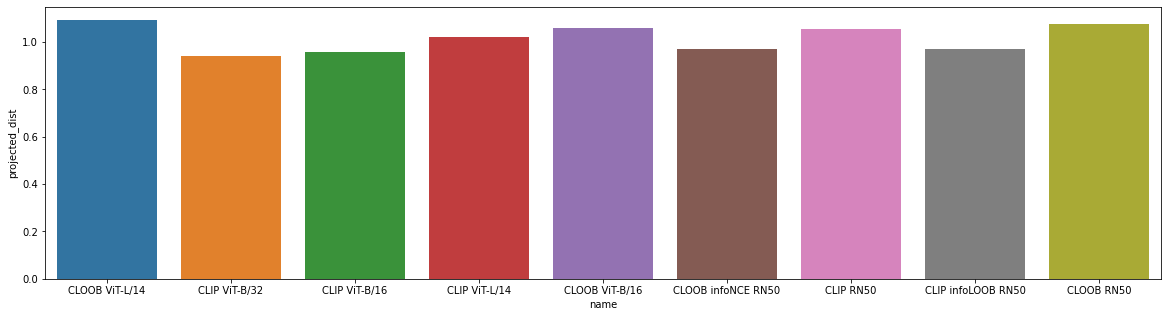

In [4]:
plt.figure(figsize=(20, 5))
seaborn.barplot(data=results, x="name", y="projected_dist")